# Data Exploration

Exploratory analysis of the Landing Gear digital twin dataset.

## Setup

Import standard data science libraries (`pandas`, `numpy`, `matplotlib`, `seaborn`) and apply a consistent `whitegrid` plot theme for all subsequent visualisations.

In [1]:
# Imports and default plot style
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme(style="whitegrid", context="notebook")  # consistent plot styling

## Load Dataset

Read the raw CSV file into a DataFrame and print a quick shape summary. The dataset contains simulated landing gear measurements with nine columns: a run identifier, three dynamic response signals (`Max_Deflection`, `Max_Velocity`, `Settling_Time`), two structural parameters (`Mass`, `K_Stiffness`, `B_Damping`), a categorical `Fault_Code`, and the regression target `RUL` (Remaining Useful Life in cycles).

In [2]:
# Load dataset and preview
DATA_PATH = Path("../data/raw/LandingGear_Balanced_Dataset.csv")
df = pd.read_csv(DATA_PATH)
print(f"Loaded {len(df):,} rows and {df.shape[1]} columns from {DATA_PATH}")

df.head()


Loaded 1,500 rows and 9 columns from ..\data\raw\LandingGear_Balanced_Dataset.csv


,RunID,Max_Deflection,Max_Velocity,Settling_Time,Mass,K_Stiffness,B_Damping,Fault_Code,RUL
0,1,0.3,0.592124,0.330689,4653.503425,156086.879056,3850.794727,0,97.220855
1,2,0.3,0.619103,0.345473,3187.526077,143963.106075,3911.399288,0,94.485389
2,3,0.3,0.589439,0.330372,4882.371127,156973.328028,3863.045233,0,99.362603
3,4,0.3,0.594537,0.348994,1567.545355,149780.634731,4120.112188,0,99.357504
4,5,0.3,0.579618,0.341858,4837.969706,156236.032878,4116.882932,0,91.326419


## Data Quality & Descriptive Statistics

Build a concise audit table showing each column's dtype, non-null count, and missing-value count — confirming the dataset is complete (no nulls). `describe().T` then provides per-feature min/max, quartiles, mean, and standard deviation, giving a first sense of the numerical ranges and variability of each signal.

In [3]:
# Data types, completeness, and basic stats
summary = pd.DataFrame(
    {
        "dtype": df.dtypes,
        "non_null": df.notnull().sum(),  # quick completeness check
        "missing": df.isnull().sum(),
    }
)
display(summary)

df.describe().T

,dtype,non_null,missing
RunID,int64,1500,0
Max_Deflection,float64,1500,0
Max_Velocity,float64,1500,0
Settling_Time,float64,1500,0
Mass,float64,1500,0
K_Stiffness,float64,1500,0
B_Damping,float64,1500,0
Fault_Code,int64,1500,0
RUL,float64,1500,0


,count,mean,std,min,25%,50%,75%,max
RunID,1500.0,750.500000,433.157015,1.000000,375.750000,750.500000,1125.250000,1500.000000
Max_Deflection,1500.0,0.300018,0.000156,0.300000,0.300000,0.300000,0.300000,0.301976
Max_Velocity,1500.0,0.673895,0.071852,0.574557,0.614667,0.657142,0.714344,0.914319
Settling_Time,1500.0,0.393192,0.069448,0.317767,0.338473,0.365980,0.444915,0.653655
Mass,1500.0,3013.640972,1156.133997,1001.365849,2020.267452,3062.448216,4010.413004,4997.911435
K_Stiffness,1500.0,136978.482654,19948.112877,80000.000000,131075.000000,147287.835278,150000.000000,157492.374301
B_Damping,1500.0,3431.891548,848.728578,1000.000000,3217.250000,3891.532860,4000.000000,4199.632158
Fault_Code,1500.0,1.400000,0.952508,0.000000,1.000000,1.000000,2.000000,3.000000
RUL,1500.0,62.102630,29.634244,0.000000,37.400000,72.062500,87.653833,99.930846


## Fault Code Class Distribution

Count the occurrences of each `Fault_Code` label (0 = healthy, 1–3 = fault types) and display the counts as a bar chart. This confirms whether the dataset is balanced across classes — a prerequisite for unbiased classifier training.

Fault code distribution:
 Fault_Code
0    300
1    500
2    500
3    200
Name: count, dtype: int64


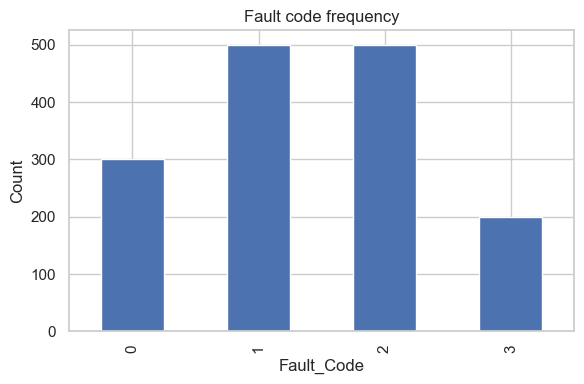

In [4]:
# Fault_Code class distribution
fault_counts = df["Fault_Code"].value_counts().sort_index()  # balanced class check
print("Fault code distribution:\n", fault_counts)

ax = fault_counts.plot(kind="bar", figsize=(6, 4), color="#4c72b0")
ax.set_xlabel("Fault_Code")
ax.set_ylabel("Count")
ax.set_title("Fault code frequency")
plt.tight_layout()
plt.show()

## Physics-Derived Features

Engineer two interpretable, physics-based features directly from the structural parameters:

- **Damping ratio** ζ = B / (2√(K · m)) — a dimensionless measure of how quickly oscillations decay; values < 1 indicate under-damped (bouncy) behaviour, typical of landing gear that has lost damping capacity.
- **Natural frequency** ω_n = √(K / m) — the frequency (rad/s) at which the strut would oscillate freely; shifts in ω_n indicate changes in stiffness or mass distribution.

These quantities connect the raw sensor data to established structural-dynamics theory, making them physically meaningful inputs for predictive models.

In [5]:
# Derived physics metrics for landing gear dynamics
df["zeta_damping_ratio"] = df["B_Damping"] / (2 * np.sqrt(df["K_Stiffness"] * df["Mass"]))  # dimensionless damping ratio
df["omega_n"] = np.sqrt(df["K_Stiffness"] / df["Mass"])  # natural frequency (rad/s)
df[["zeta_damping_ratio", "omega_n"]].describe().T

,count,mean,std,min,25%,50%,75%,max
zeta_damping_ratio,1500.0,0.092305,0.035045,0.019334,0.071427,0.089540,0.113487,0.208692
omega_n,1500.0,7.193671,1.758999,4.072703,5.875925,6.702787,8.178920,12.254547


## Physics Metrics by Fault Class

Side-by-side box plots compare the distributions of ζ (damping ratio) and ω_n (natural frequency) across the four fault codes. Systematic shifts in median or spread between classes indicate that these physics-derived features carry discriminative information useful for fault classification.

C:\Users\Zsolti\AppData\Local\Temp\ipykernel_18676\1512779764.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Fault_Code", y="zeta_damping_ratio", palette="viridis", ax=axes[0])
C:\Users\Zsolti\AppData\Local\Temp\ipykernel_18676\1512779764.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Fault_Code", y="omega_n", palette="viridis", ax=axes[1])


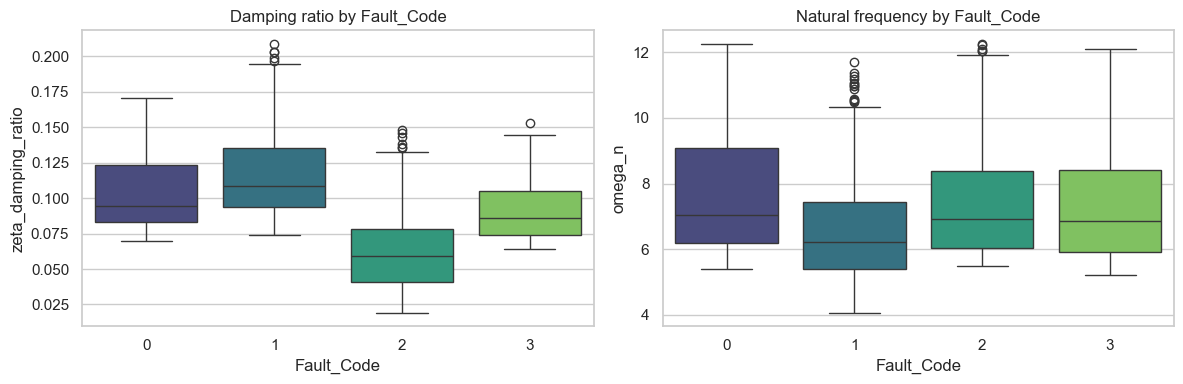

In [6]:
# Compare derived physics metrics across fault classes
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # boxplots to compare physics metrics across faults
sns.boxplot(data=df, x="Fault_Code", y="zeta_damping_ratio", palette="viridis", ax=axes[0])
axes[0].set_title("Damping ratio by Fault_Code")
sns.boxplot(data=df, x="Fault_Code", y="omega_n", palette="viridis", ax=axes[1])
axes[1].set_title("Natural frequency by Fault_Code")
plt.tight_layout()
plt.show()

## RUL vs Physics-Derived Metrics

Scatter plots of RUL against ζ and ω_n, coloured by `Fault_Code`, reveal whether the physics features have a monotonic or structured relationship with remaining life. Clear trends here would support using these features as direct inputs to a regression model; clustering by colour also shows whether fault type modulates the RUL–physics relationship.

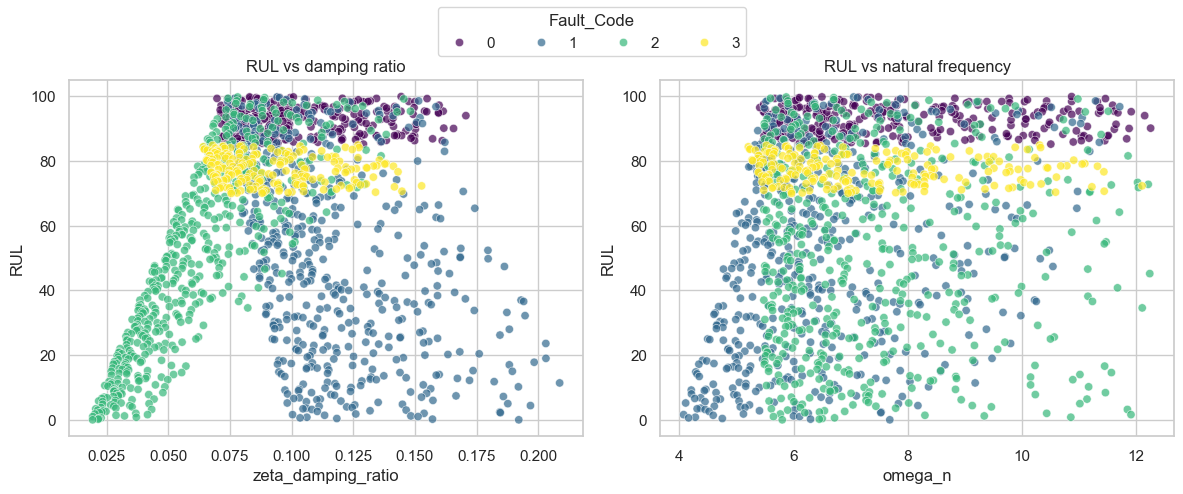

In [7]:
# RUL relationship with physics-derived metrics
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # RUL relationship with physics metrics
sns.scatterplot(data=df, x="zeta_damping_ratio", y="RUL", hue="Fault_Code", palette="viridis", alpha=0.7, ax=axes[0])
axes[0].set_title("RUL vs damping ratio")
sns.scatterplot(data=df, x="omega_n", y="RUL", hue="Fault_Code", palette="viridis", alpha=0.7, ax=axes[1])
axes[1].set_title("RUL vs natural frequency")
for ax in axes:
    ax.legend_.remove()
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Fault_Code", loc="upper center", ncol=4)
plt.tight_layout(rect=(0, 0, 1, 0.92))
plt.show()

## RUL Distribution

A histogram with a Kernel Density Estimation (KDE) overlay shows the overall spread of the target variable. Understanding whether RUL is roughly uniform, skewed, or multi-modal informs the choice of loss function and model evaluation metrics for the regression task.

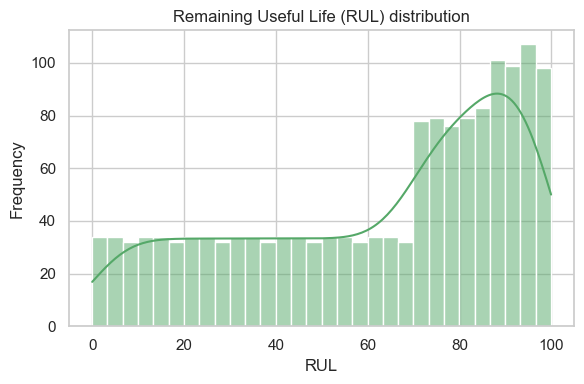

In [8]:
# Distribution of Remaining Useful Life
plt.figure(figsize=(6, 4))  # overall RUL distribution
sns.histplot(df["RUL"], bins=30, kde=True, color="#55a868")
plt.title("Remaining Useful Life (RUL) distribution")
plt.xlabel("RUL")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## Feature Correlation Matrix

A colour-coded heatmap of Pearson correlations between all numeric features (excluding `RunID`). High pairwise correlations signal multicollinearity, which can inflate variance in linear models and affect feature-importance rankings in tree-based models. This view also highlights which raw features are most linearly related to `RUL`.

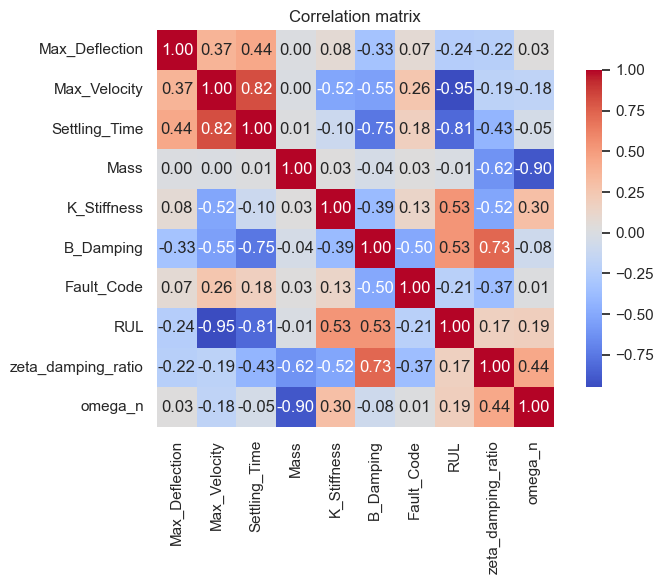

In [9]:
# Feature correlation matrix
num_cols = df.select_dtypes(include=[np.number]).columns.drop('RunID', errors='ignore')  # drop identifier from correlations
corr = df[num_cols].corr()  # feature correlation to spot collinearity
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()


## RUL vs Individual Features (by Fault Class)

A 2×3 grid of scatter plots — one per sensor/derived feature — each showing RUL on the y-axis and the feature on the x-axis, coloured by `Fault_Code`. This reveals which individual features have the strongest or most structured relationship with remaining life, and whether that relationship differs by fault type.

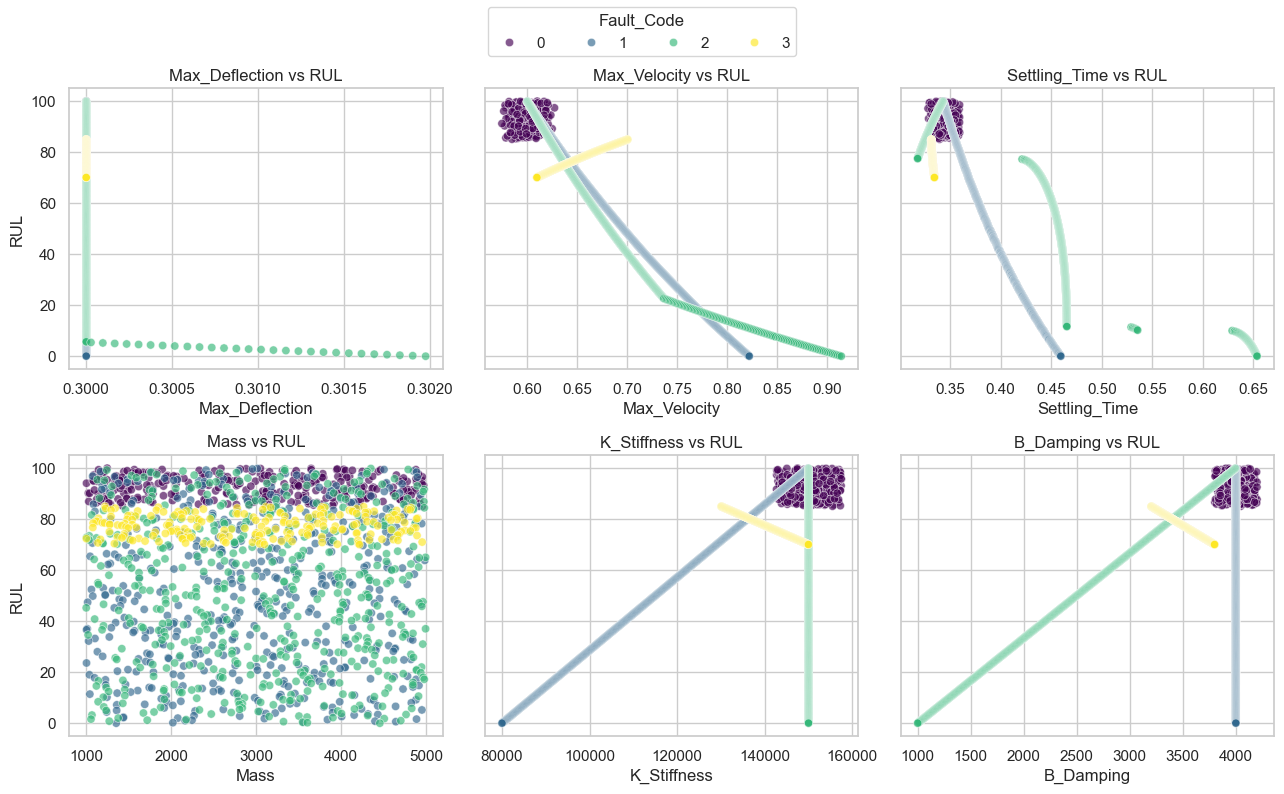

In [ ]:
# Scatter plots of RUL vs features by fault class
feature_cols = [col for col in num_cols if col not in ("RunID", "RUL", "Fault_Code")] # focus on sensor/derived features
fig, axes = plt.subplots(2, 3, figsize=(13, 8), sharey=True)

for ax, col in zip(axes.flat, feature_cols):
    sns.scatterplot(data=df, x=col, y="RUL", hue="Fault_Code", palette="viridis", alpha=0.65, ax=ax)
    ax.set_title(f"{col} vs RUL")
    ax.legend_.remove()

handles, labels = axes.flat[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Fault_Code", loc="upper center", ncol=4)
plt.tight_layout(rect=(0, 0, 1, 0.94))
plt.show()

## Feature Distributions by Fault Class

A 2×3 grid of box plots — one per feature — grouped by `Fault_Code`. Differences in medians and interquartile ranges across fault classes indicate that a feature separates the classes well, which is useful for both fault-type classification and for understanding what physical changes each fault type induces in the landing gear system.

C:\Users\Zsolti\AppData\Local\Temp\ipykernel_18676\2726702340.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Fault_Code", y=col, palette="viridis", ax=ax)
C:\Users\Zsolti\AppData\Local\Temp\ipykernel_18676\2726702340.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Fault_Code", y=col, palette="viridis", ax=ax)
C:\Users\Zsolti\AppData\Local\Temp\ipykernel_18676\2726702340.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Fault_Code", y=col, palette="viridis", ax=ax)
C:\Users\Zsolti\AppData\Local\T

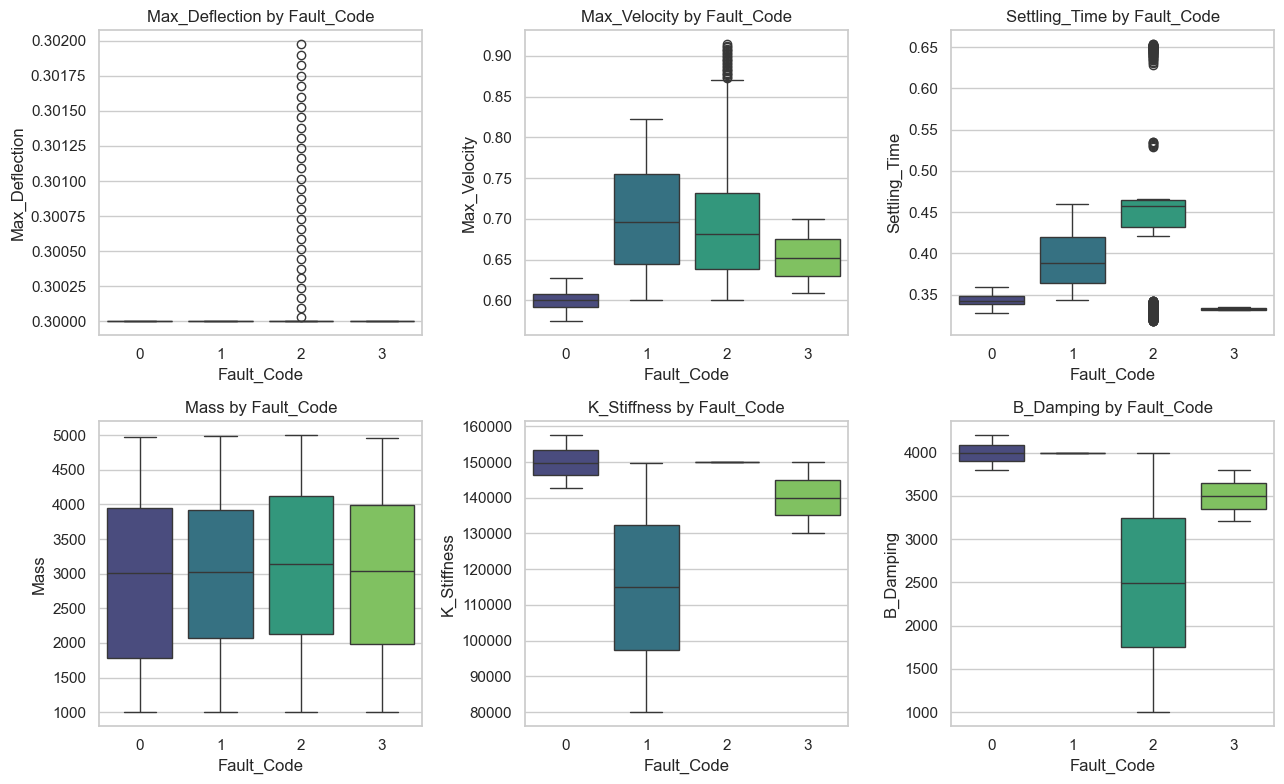

In [11]:
# Boxplots of features grouped by fault class
fig, axes = plt.subplots(2, 3, figsize=(13, 8))
for ax, col in zip(axes.flat, feature_cols):
    sns.boxplot(data=df, x="Fault_Code", y=col, palette="viridis", ax=ax)
    ax.set_title(f"{col} by Fault_Code")

plt.tight_layout()
plt.show()